# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Loading The Data

In [2]:
# Hyperparameters
learning_rate = 0.001
batch_size = 128
num_epochs = 30

In [3]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
                                      transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

transform_test = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

cifar10_dataset = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)

train_size = int(0.8 * len(cifar10_dataset))
val_size = len(cifar10_dataset) - train_size
train_dataset, val_dataset = random_split(cifar10_dataset, [train_size, val_size])

test_dataset = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

100%|██████████| 170498071/170498071 [00:03<00:00, 48997196.13it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Checking Unbalance In The Classes

In [4]:
labels = [label for _, label in cifar10_dataset]

class_counts = Counter(labels)

sorted_class_counts = sorted(class_counts.items())

for digit, count in sorted_class_counts:
    print(f"Class {digit}: {count} images")

Class 0: 5000 images
Class 1: 5000 images
Class 2: 5000 images
Class 3: 5000 images
Class 4: 5000 images
Class 5: 5000 images
Class 6: 5000 images
Class 7: 5000 images
Class 8: 5000 images
Class 9: 5000 images


## Visualize A Batch Of Training Data

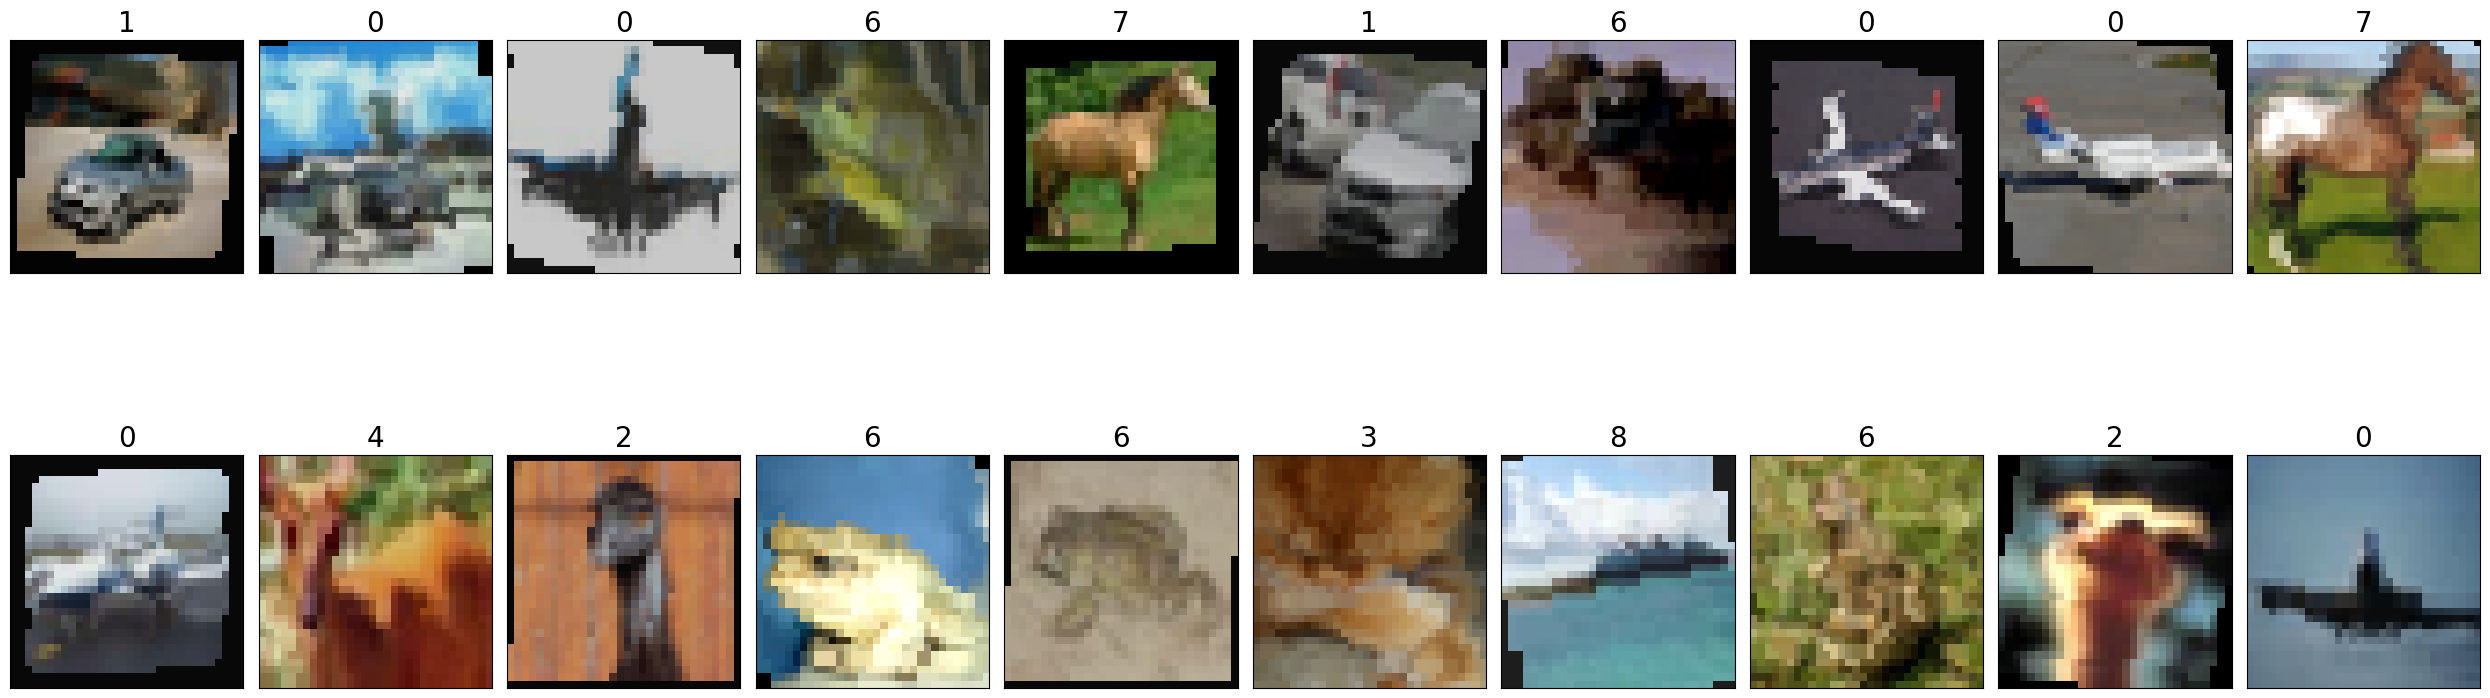

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images / 2 + 0.5
images = torch.clamp(images, 0, 1)
images = images.numpy()


fig = plt.figure(figsize = (25, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
    image = np.transpose(images[idx], (1, 2, 0))
    ax.imshow(image)
    ax.set_title(str(labels[idx].item()), fontsize = 20)

plt.tight_layout()
plt.show()

# Building The Network

In [6]:
def conv(channels_in, channels_out):
    return nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1, bias=False)

def pool(channels_in):
    return nn.Conv2d(channels_in, channels_in, kernel_size=2, stride=2, bias=False)

def conv1x1(channels_in, channels_out):
    return nn.Conv2d(channels_in, channels_out, kernel_size=1, stride=1)

def bn(channels_in):
    return nn.BatchNorm2d(channels_in)

def relu():
    return nn.ReLU()

def dropout(rate):
    return nn.Dropout(rate)

In [7]:
class Layer(nn.Sequential):
    def __init__(self, channels):
        super(Layer, self).__init__()
        self.add_module('norm', bn(channels))
        self.add_module('relu', relu())
        self.add_module('conv', conv(channels, channels))

In [8]:
class ResBlock(nn.Module):
    def __init__(self, channels, number_of_layers):
        super(ResBlock, self).__init__()
        self.layers = nn.ModuleList([Layer(channels) for _ in range(number_of_layers)])

    def forward(self, input_data):
        residual = input_data
        for layer in self.layers:
            output = layer(input_data)
            input_data = output + residual
            residual = input_data
        return input_data

In [9]:
class Transition_Layer(nn.Sequential):
    def __init__(self, channels_in, channels_out):
        super(Transition_Layer, self).__init__()
        self.add_module('norm', bn(channels_in))
        self.add_module('relu', nn.ReLU())
        self.add_module('conv1x1', conv1x1(channels_in, channels_out))
        self.add_module('pool', pool(channels_out))
        self.add_module('dropout', dropout(0.1))

In [10]:
class stage(nn.Sequential):
    def __init__(self, channels_in, channels_out, number_of_layers):
        super(stage, self).__init__()
        self.add_module('res_block', ResBlock(channels_in, number_of_layers))
        self.add_module('transition_layer', Transition_Layer(channels_in, channels_out))

In [11]:
class ResNet(nn.Sequential):
    def __init__(self):
        super(ResNet, self).__init__()
        self.add_module('stage1', stage(3, 32, 5))
        self.add_module('stage2', stage(32, 64, 5))
        self.add_module('stage3', stage(64, 128, 5))
        self.add_module('stage4', stage(128, 64, 5))
        self.add_module('stage5', stage(64, 16, 5))
        self.add_module('res_block_final', ResBlock(16, 5))
        self.add_module('conv1x1', conv1x1(16, 10))
        self.add_module('flatten', nn.Flatten())

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
model = ResNet().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr = learning_rate,
)

In [15]:
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [128, 10]                 --
├─stage: 1-1                                  [128, 32, 16, 16]         --
│    └─ResBlock: 2-1                          [128, 3, 32, 32]          --
│    │    └─ModuleList: 3-1                   --                        435
│    └─Transition_Layer: 2-2                  [128, 32, 16, 16]         --
│    │    └─BatchNorm2d: 3-2                  [128, 3, 32, 32]          6
│    │    └─ReLU: 3-3                         [128, 3, 32, 32]          --
│    │    └─Conv2d: 3-4                       [128, 32, 32, 32]         128
│    │    └─Conv2d: 3-5                       [128, 32, 16, 16]         4,096
│    │    └─Dropout: 3-6                      [128, 32, 16, 16]         --
├─stage: 1-2                                  [128, 64, 8, 8]           --
│    └─ResBlock: 2-3                          [128, 32, 16, 16]         --
│    │    └─Modu

# Training The Model

In [16]:
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data, targets in tqdm(train_loader):
        data = data.to(device = device)
        targets = targets.to(device = device)

        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device = device)
            targets = targets.to(device = device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

100%|██████████| 313/313 [00:21<00:00, 14.62it/s]


Epoch: 1, Training Loss: 1.833751, Validation Loss: 1.643155


100%|██████████| 313/313 [00:21<00:00, 14.48it/s]


Epoch: 2, Training Loss: 1.504598, Validation Loss: 1.428608


100%|██████████| 313/313 [00:21<00:00, 14.77it/s]


Epoch: 3, Training Loss: 1.340050, Validation Loss: 1.293216


100%|██████████| 313/313 [00:21<00:00, 14.70it/s]


Epoch: 4, Training Loss: 1.221843, Validation Loss: 1.182072


100%|██████████| 313/313 [00:20<00:00, 15.29it/s]


Epoch: 5, Training Loss: 1.135771, Validation Loss: 1.148147


100%|██████████| 313/313 [00:20<00:00, 15.26it/s]


Epoch: 6, Training Loss: 1.075058, Validation Loss: 1.093696


100%|██████████| 313/313 [00:20<00:00, 14.97it/s]


Epoch: 7, Training Loss: 1.005923, Validation Loss: 0.940149


100%|██████████| 313/313 [00:20<00:00, 14.94it/s]


Epoch: 8, Training Loss: 0.963792, Validation Loss: 0.952212


100%|██████████| 313/313 [00:20<00:00, 14.91it/s]


Epoch: 9, Training Loss: 0.927882, Validation Loss: 0.974607


100%|██████████| 313/313 [00:20<00:00, 15.31it/s]


Epoch: 10, Training Loss: 0.892267, Validation Loss: 0.865449


100%|██████████| 313/313 [00:20<00:00, 15.17it/s]


Epoch: 11, Training Loss: 0.863331, Validation Loss: 1.014350


100%|██████████| 313/313 [00:20<00:00, 15.05it/s]


Epoch: 12, Training Loss: 0.829909, Validation Loss: 0.793066


100%|██████████| 313/313 [00:20<00:00, 15.11it/s]


Epoch: 13, Training Loss: 0.811821, Validation Loss: 0.840521


100%|██████████| 313/313 [00:20<00:00, 14.92it/s]


Epoch: 14, Training Loss: 0.788139, Validation Loss: 0.854617


100%|██████████| 313/313 [00:20<00:00, 15.19it/s]


Epoch: 15, Training Loss: 0.760721, Validation Loss: 0.804601


100%|██████████| 313/313 [00:20<00:00, 15.29it/s]


Epoch: 16, Training Loss: 0.747766, Validation Loss: 0.727368


100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


Epoch: 17, Training Loss: 0.738283, Validation Loss: 0.739375


100%|██████████| 313/313 [00:20<00:00, 15.10it/s]


Epoch: 18, Training Loss: 0.714137, Validation Loss: 0.706754


100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


Epoch: 19, Training Loss: 0.696562, Validation Loss: 0.706163


100%|██████████| 313/313 [00:21<00:00, 14.81it/s]


Epoch: 20, Training Loss: 0.687445, Validation Loss: 0.744324


100%|██████████| 313/313 [00:20<00:00, 15.26it/s]


Epoch: 21, Training Loss: 0.666331, Validation Loss: 0.691742


100%|██████████| 313/313 [00:20<00:00, 15.25it/s]


Epoch: 22, Training Loss: 0.650634, Validation Loss: 0.766842


100%|██████████| 313/313 [00:21<00:00, 14.77it/s]


Epoch: 23, Training Loss: 0.647693, Validation Loss: 0.668151


100%|██████████| 313/313 [00:20<00:00, 15.05it/s]


Epoch: 24, Training Loss: 0.637606, Validation Loss: 0.675923


100%|██████████| 313/313 [00:20<00:00, 15.14it/s]


Epoch: 25, Training Loss: 0.627110, Validation Loss: 0.665425


100%|██████████| 313/313 [00:20<00:00, 15.12it/s]


Epoch: 26, Training Loss: 0.611165, Validation Loss: 0.648704


100%|██████████| 313/313 [00:20<00:00, 15.34it/s]


Epoch: 27, Training Loss: 0.604159, Validation Loss: 0.675685


100%|██████████| 313/313 [00:21<00:00, 14.90it/s]


Epoch: 28, Training Loss: 0.592651, Validation Loss: 0.621814


100%|██████████| 313/313 [00:21<00:00, 14.87it/s]


Epoch: 29, Training Loss: 0.586806, Validation Loss: 0.633232


100%|██████████| 313/313 [00:21<00:00, 14.88it/s]


Epoch: 30, Training Loss: 0.574546, Validation Loss: 0.602766


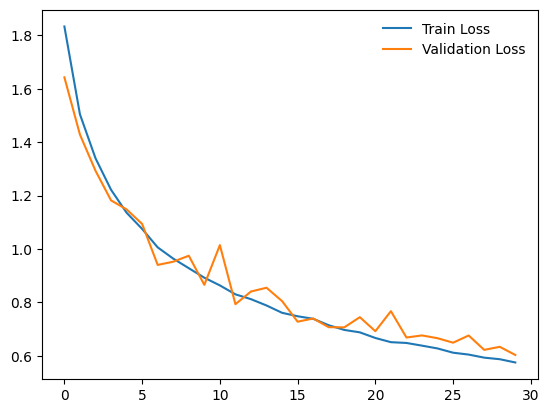

In [17]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.legend(frameon = False)

# Testing The Model

In [18]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device)
            y = y.to(device = device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on Training set: {check_accuracy(train_loader, model) * 100:.2f}%")
print(f"Accuracy on Test set: {check_accuracy(test_loader, model) * 100:.2f}%")

Accuracy on Training set: 82.77%
Accuracy on Test set: 82.18%


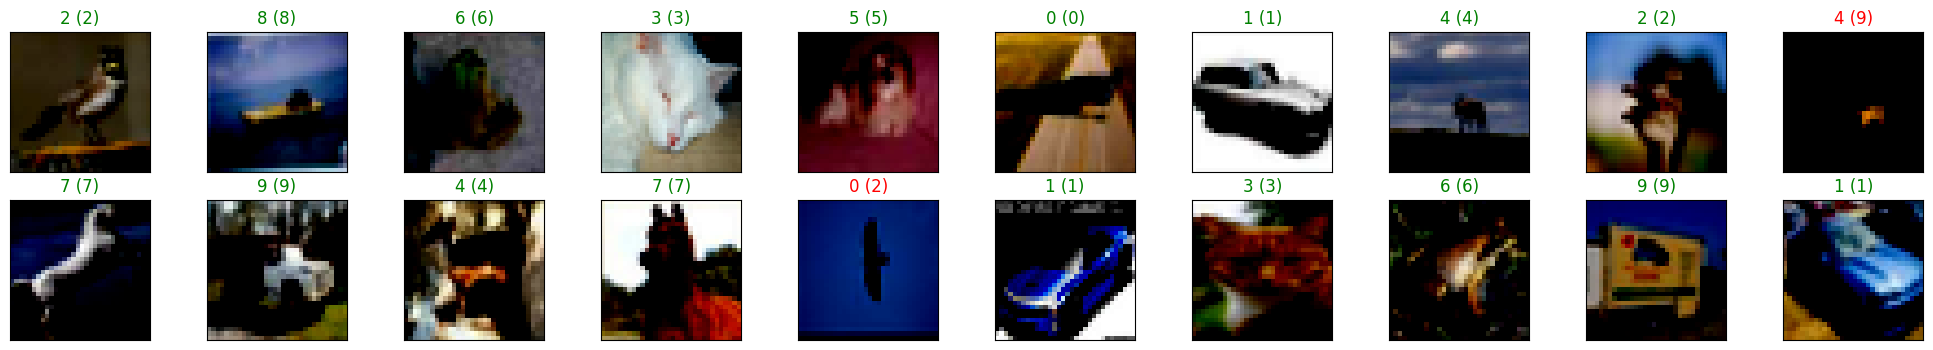

In [19]:
dataiter = iter(test_loader)
data, targets = next(dataiter)

data, targets = data.to(device), targets.to(device)

output = model(data)
_, preds = torch.max(output, 1)

data = data.cpu().numpy()
targets = targets.cpu().numpy()
preds = preds.cpu().numpy()

data = np.transpose(data, (0, 2, 3, 1))

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    img = np.clip(data[idx], 0, 1)
    ax.imshow(img)
    ax.set_title("{} ({})".format(str(preds[idx]), str(targets[idx])),
                 color=("green" if preds[idx] == targets[idx] else "red"))
plt.show()